In [1]:
## Import packages
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

from scipy import fftpack
from scipy.signal import find_peaks
import matplotlib.patheffects as pe

from matplotlib.animation import FuncAnimation
import math
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
font_size = 14



In [2]:
## Dimensional operators
cav_dim = 2 # total number of possible photons
atm_dim = 2 # energy levels in atom, 2 for TLS
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field (2, one for vacuum state, one for excited states)
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Total atomic operators
sigmap_tot = tensor(sigmap(), I_cav)
sigmam_tot = tensor(sigmam(), I_cav)
sigmaz_tot = tensor(sigmaz(), I_cav)

## Photon operators
adag = create(cav_dim)
a = destroy(cav_dim)
adag_tot = tensor(I_atom, adag) # order of arguments is important and is consistant with the spin operators #add .unit()               
a_tot = tensor(I_atom, a)

## Physical constants
N = 7e14 # number of two-level systems
wa = 2 * np.pi * 1.45e3 # atom transition frequency between levels X & Z (MHz) allows is to work in micro seconds
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)
gs = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimentally it's 1.1 though.
g = 3 #2 * np.pi * 1.1 # test spin-photon couling strength ~ np.sqrt(tls_num)*gs, experimetnally it's 1.1 though.

Kc = 0.07 # 2 * np.pi * 0.18 # cavity mode decay rate (MHz) # derivation can be found in Agarwal pg.31
Ks = 0.23 #2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma = 0.0 # 2 * np.pi * 0.0177 # spin-lattice relaxation rate between X and Z

## Initial quantum states
psi_atm = np.sqrt(0)*basis(2,0) + np.sqrt(1)*basis(2,1) # atom begins in ground state
rho_atm = ket2dm(psi_atm)
psi_phot = np.sqrt(1)*fock(cav_dim, 1)
rho_phot = ket2dm(psi_phot)
psi0 = tensor(psi_atm, psi_phot)
rho = tensor(rho_atm, rho_phot)

## Simulation initialization
time = 30
steps = 2000
tlist = np.linspace(0, time, steps) # duration and steps to be used in evolution
step_size = tlist[1] - tlist[0]


In [3]:
""" Explicit Method """

## Observable initialization
n_phot_list = [((adag * a) * rho.ptrace(1)).tr()] # number of photons in light field

# Tuneable parameters
use_rwa = True # set = True to use Rotating Wave Approximation
n_th = 0 # avg number of thermal bath excitation (nhf=kT)

## function computing the Lindblad master equation
def lindblad(p):
    
    ## Assembling the Hamiltonian
    HA = 0.5 * wa * sigmaz_tot # atomic part
    HF = wc * adag_tot * a_tot # field part

    if use_rwa:
        HI = sigmap_tot*a_tot + sigmam_tot*adag_tot # interaction part in the RWA
    else:
        HI = hbar * ((sigmap_tot + sigmam_tot)*(a_tot + adag_tot)) # interaction part not using RWA

    H = HA + HF + g*HI
    
    ## Liouvillian
    closed_system = -1j * commutator(H,p)
    cavity_decay = Kc/2 * (adag_tot*a_tot*p - 2*a_tot*p*adag_tot + p*adag_tot*a_tot)
    spin_relax = gamma/2 * (sigmap_tot*sigmam_tot*p - 2*sigmam_tot*p*sigmap_tot + p*sigmap_tot*sigmam_tot)
    spin_dephase = Ks/2 * (sigmaz_tot.dag()*sigmaz_tot*rho - 2*sigmaz_tot*rho*sigmaz_tot.dag() + rho*sigmaz_tot.dag()*sigmaz_tot)
    
    return closed_system - cavity_decay - spin_relax - spin_dephase



## RK4 method realized using a for loop
for step_index in range(steps-1):
    
    ## RK4 method
    k1 = step_size * lindblad(rho)
    k2 = step_size * lindblad(rho + 0.5*k1)
    k3 = step_size * lindblad(rho + 0.5*k2)
    k4 = step_size * lindblad(rho + k3)
    rho += 1/6*k1 + 1/3*(k2+k3) + 1/6*k4      # calculation of density matrix at n+1 step
    
#     #RK2 method
#     rho_pred = rho + 3/4 * lindblad(rho, N) * step_size # Predictor
#     rho_dash = rho_pred - 5/12 * lindblad(rho, N) * step_size
#     rho = rho_dash + 2/3 * lindblad(rho, N) * step_size # Corrector
    
    
    ## calculating observables at n+1 step using density matrix found above and adding them to list 
    n_phot_new = (((adag*a) * rho.ptrace(1)).tr().real)
    n_phot_list = np.append(n_phot_list, n_phot_new)
    
    

In [4]:
def locpeaks(ydata):

    # for local maxima
    peak_indx = argrelextrema(ydata, np.greater)[0] # zero is necessary to flatten tuple
    peak_pos = peak_indx /steps * time 
    peak_data = ydata[argrelextrema(ydata, np.greater)[0]]
    
    # checking that if a maxima occurs at t=0, it is included
    if np.argmax(ydata) == 0:
        peak_times = np.insert(peak_pos, 0, 0)
        peak_vals = np.insert(peak_data, 0, ydata[0])    
    else: 
        peak_times = peak_pos
        peak_vals = peak_data
        
    
    # for local minima
    trough_indx = argrelextrema(ydata, np.less)[0] # zero is necessary to flatten tuple
    trough_pos = trough_indx /steps * time 
    trough_data = ydata[argrelextrema(ydata, np.less)[0]]
        
    # checking that if a minima occurs at t=0, it is included
    if np.argmin(ydata) == 0:
        trough_times = np.insert(trough_pos, 0, 0)
        trough_vals = np.insert(trough_data, 0, ydata[0]) 
    else: 
        trough_times = trough_pos
        trough_vals = trough_data
    
    return [peak_times, peak_vals], [trough_times, trough_vals]

phot_peaks, phot_troughs = locpeaks(n_phot_list)


In [5]:
def curvefit(points):

    # fitting functions
    def exp(x, a, b, c):
        return a*np.exp(-b*x) + c # exponential decay

    def gaus(x, a, b, c):
        return a*np.exp(-(x-b)**2 /c) # gaussian envelope

    # optimization of fit parameter using curve_fit
    popt1, pcov1 = curve_fit(exp, points[0], points[1], maxfev = 1500) #points[0] and points[1] are x and y data respectively
    popt2, pcov2 = curve_fit(gaus, points[0], points[1], maxfev = 5000000)

    print(popt1)
    
    # generating fit data for plotting
    fit1 = [] # ydata for exponential fit function
    fit2 = [] # ydata for gaussian fit function
    for i in tlist:
        fit1.append(exp(i, popt1[0], popt1[1], popt1[2])) # calculate y values of exponential fit function at each time step and append to ydata list
        fit2.append(gaus(i, popt2[0], popt2[1], popt2[2])) # calculate y values of gaussian fit function at each time step and append to ydata list

    return fit1, fit2

phot_peaks_fit1, phot_peaks_fit2 = curvefit(phot_peaks)



[0.74742509 0.16442716 0.23257327]


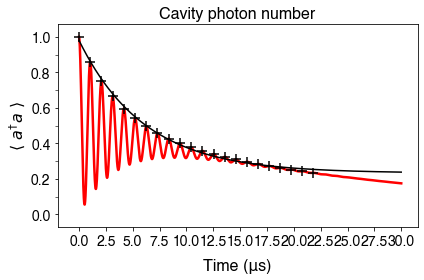

In [6]:
## Visualization

fig, ax = plt.subplots(figsize=(6,4))
plt.figure(1)
plt.plot(tlist, n_phot_list, color='r', linestyle='-', linewidth=2.5, zorder=0, label='explicit sol.')
plt.scatter(phot_peaks[0], phot_peaks[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.plot(tlist, phot_peaks_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2, label= "exp. fit: a=0.99629071 \n             b=0.22577594 \n             c=0.00277341")
plt.ylim([-0.07, 1.07])
plt.title('Cavity photon number', fontsize = 16)
plt.ylabel(r'$\langle\ a^\dag a \ \rangle$', fontsize = 16)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=3)
#plt.legend(fancybox=False, edgecolor='w', fontsize=13)
plt.tight_layout()
#plt.savefig('adag a.png', format = 'png', dpi = 900) 




In [7]:
locpeaks(n_phot_list)

([array([ 0.   ,  1.035,  2.085,  3.135,  4.17 ,  5.22 ,  6.27 ,  7.305,
          8.355,  9.405, 10.44 , 11.49 , 12.525, 13.575, 14.61 , 15.645,
         16.68 , 17.715, 18.75 , 19.77 , 20.775, 21.78 ]),
  array([1.        , 0.86048444, 0.75149544, 0.66514324, 0.59618214,
         0.54086045, 0.49564037, 0.4582687 , 0.42706863, 0.40050633,
         0.37765765, 0.35767096, 0.33997539, 0.32408683, 0.30968784,
         0.29648218, 0.28427253, 0.27290205, 0.26224619, 0.25221951,
         0.24274555, 0.23378186])],
 [array([ 0.525,  1.56 ,  2.61 ,  3.66 ,  4.71 ,  5.745,  6.795,  7.845,
          8.895,  9.945, 10.995, 12.045, 13.095, 14.145, 15.195, 16.245,
         17.31 , 18.36 , 19.425, 20.505, 21.6  ]),
  array([0.05508111, 0.14327389, 0.20605592, 0.250247  , 0.28041284,
         0.29999323, 0.31157349, 0.31734644, 0.31880905, 0.31709895,
         0.31307928, 0.30740366, 0.30056591, 0.29293814, 0.28479982,
         0.27635998, 0.26777133, 0.25913417, 0.25053556, 0.24202469,
         0